## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


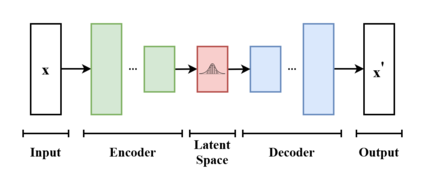

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

2025-03-29 09:32:07.216333: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 09:32:12.878711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-29 09:32:34.244428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 09:32:34.244498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 09:32:34.329893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [4]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [5]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

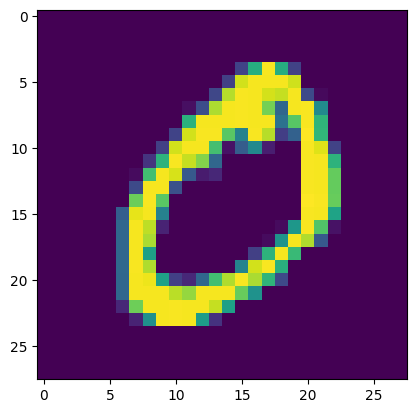

In [6]:
# Example of a training image
plt.imshow(x_tr[1]);

In [7]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [8]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [9]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [10]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [11]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 5s 4ms/step - loss: 192.7633 - val_loss: 167.4991
Epoch 2/50
600/600 [==============================] - 2s 4ms/step - loss: 163.6340 - val_loss: 160.1795
Epoch 3/50
600/600 [==============================] - 2s 4ms/step - loss: 158.7797 - val_loss: 156.8966
Epoch 4/50
600/600 [==============================] - 2s 4ms/step - loss: 155.9245 - val_loss: 154.4458
Epoch 5/50
600/600 [==============================] - 2s 4ms/step - loss: 153.6375 - val_loss: 152.4052
Epoch 6/50
600/600 [==============================] - 2s 4ms/step - loss: 151.7528 - val_loss: 151.2421
Epoch 7/50
600/600 [==============================] - 2s 4ms/step - loss: 150.7733 - val_loss: 150.0623
Epoch 8/50
600/600 [==============================] - 2s 4ms/step - loss: 148.9868 - val_loss: 148.8626
Epoch 9/50
600/600 [==============================] - 2s 4ms/step - loss: 147.6083 - val_loss: 147.7425
Epoch 10/50
600/600 [==============================] - 2s 4ms/st

### Visualize Embeddings

In [12]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

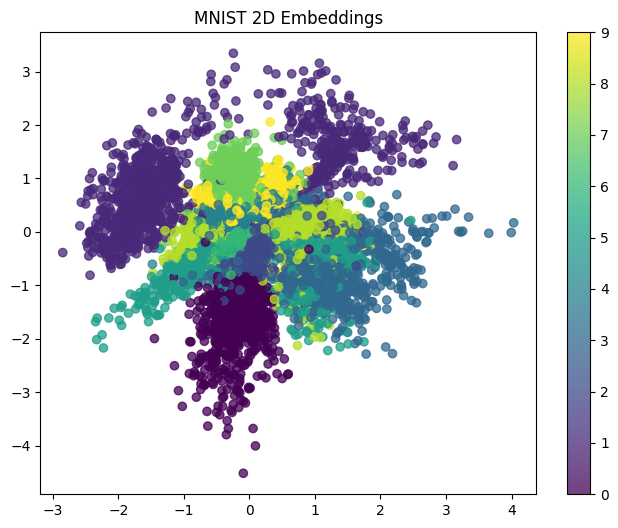

In [13]:
# Plot of the digit classes in the latent space
x_te_late- Searching for Similar Vectors
    - Distance Metrics
- Approximate Nearest Neighbors
    - ANN - Trade recall for accuracy
    - HNSW
- Vector DB’s
    - CRUD operations
    - Objects + Vectors
    - Inverted Indexnt = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

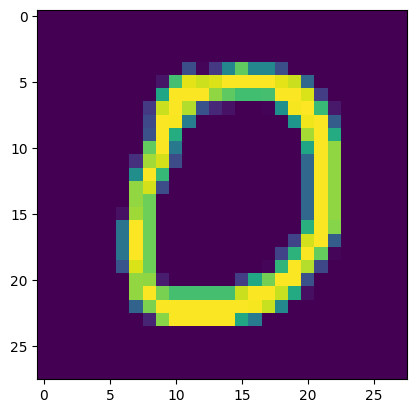

In [14]:
plt.imshow(x_te_flat[10].reshape(28,28));

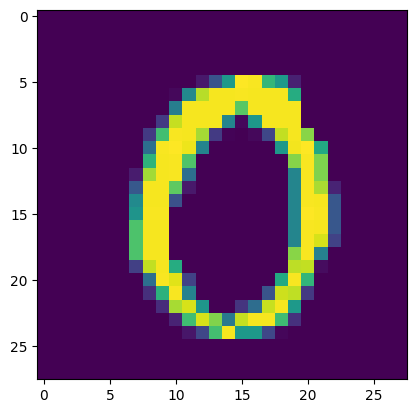

In [15]:
plt.imshow(x_te_flat[13].reshape(28,28));

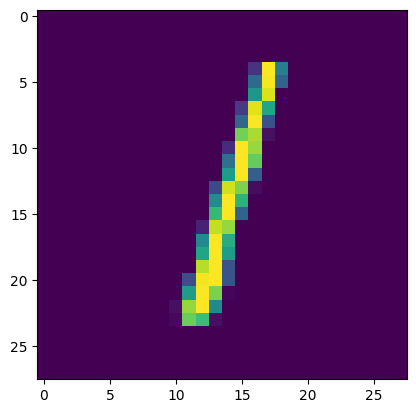

In [16]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [17]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [-0.04824911 -1.4960142 ]
Embedding for the second ZERO is [-0.0618476 -1.2668394]
Embedding for the ONE is         [-2.1215858   0.93928975]


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/744 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512_vnni.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/211k [00:00<?, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml:   0%|          | 0.00/368k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [19]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [20]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.3706196   0.26414266  0.21265697 ...  0.14994529 -0.25794923
  -0.23970787]
 [ 0.6693329   0.40094936 -0.48208413 ...  0.10645889 -1.5067163
  -0.01547364]
 [-0.26555923  0.11172373 -0.14733098 ...  0.42197487  0.88394576
   0.10763898]]


In [21]:
embedding.shape

(3, 384)

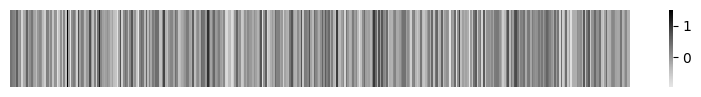

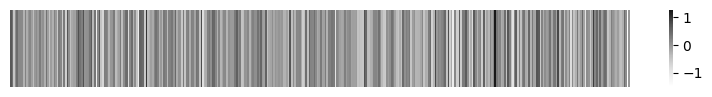

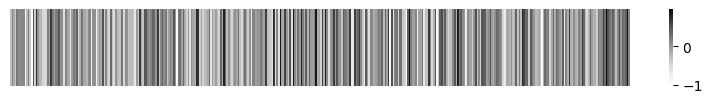

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

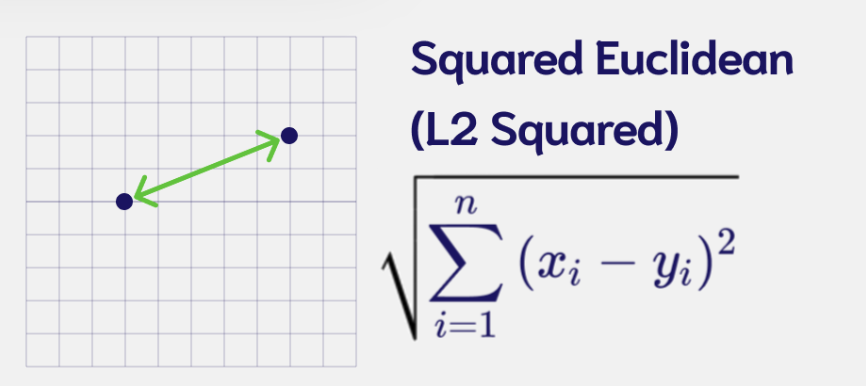

In [23]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.22957794320173305


In [24]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

0.22957794

In [25]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.22957794
Distance zeroA-one:   3.1983483
Distance zeroB-one:   3.0181992


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

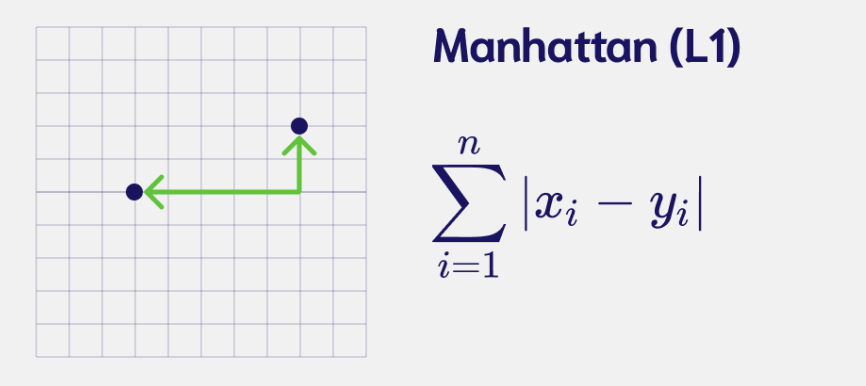

In [26]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.24277335


In [27]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

0.24277335

In [28]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.24277335
Distance zeroA-one:   4.508641
Distance zeroB-one:   4.265867


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

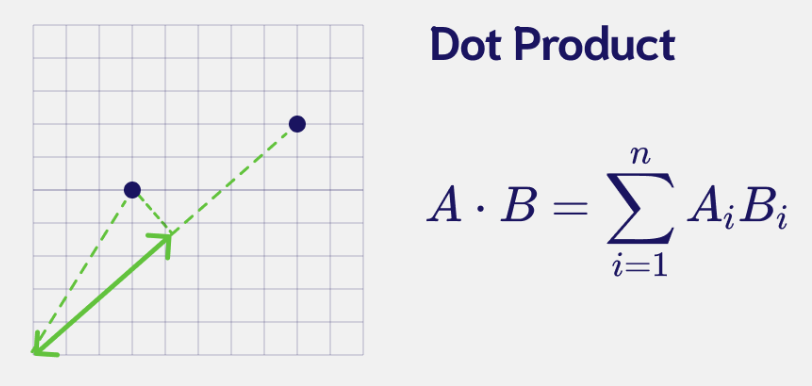

In [29]:
# Dot Product
np.dot(zero_A,zero_B)

1.8981938

In [30]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 1.8981938
Distance zeroA-one:   -1.3028262
Distance zeroB-one:   -1.0587143


### Cosine Distance
Measure the difference in directionality between vectors.

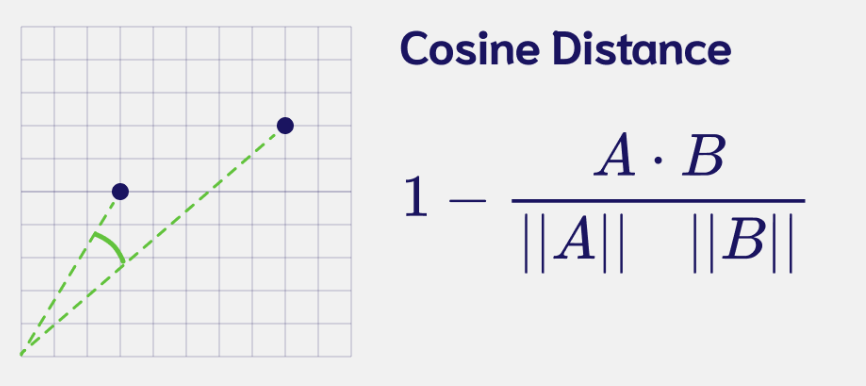

In [31]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.000137


In [32]:
zero_A/zero_B

array([0.780129 , 1.1809028], dtype=float32)

In [33]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [34]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.000137
Distance zeroA-one:    1.375143
Distance zeroB-one:    1.359760


## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [35]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497883
Distance 0-2: 2.0785882
Distance 1-2: 4.0192223


In [36]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350336730480194
Distance 0-2:  0.9639391340315342
Distance 1-2:  0.9288789108395576
